In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
from sklearn.preprocessing import StandardScaler
import joblib

In [8]:
def preprocess_data(data):
    data['DateTime'] = pd.to_datetime(data['Date-Hour(NMT)'], format='%d.%m.%Y-%H:%M')

    data['Hour_Sin'] = np.sin(2 * np.pi * data['DateTime'].dt.hour / 24)
    data['Hour_Cos'] = np.cos(2 * np.pi * data['DateTime'].dt.hour / 24)

    data = data.drop(['Date-Hour(NMT)', 'DateTime'], axis=1)

    return data


In [9]:
def create_visualizations(data):
    # 1. Correlation Heatmap
    plt.figure(figsize=(12, 8))
    correlation = data.corr()
    sns.heatmap(correlation, annot=True, cmap='coolwarm', fmt='.2f')
    plt.title('Feature Correlation Heatmap')
    plt.tight_layout()
    plt.savefig('correlation_heatmap.png')
    plt.show()
    plt.close()

    # 2. Production Relationships
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    sns.scatterplot(data=data, x='Radiation', y='SystemProduction', alpha=0.5)
    plt.title('Radiation vs System Production')

    plt.subplot(1, 3, 2)
    sns.scatterplot(data=data, x='AirTemperature', y='SystemProduction', alpha=0.5)
    plt.title('Temperature vs System Production')

    plt.subplot(1, 3, 3)
    sns.scatterplot(data=data, x='Sunshine', y='SystemProduction', alpha=0.5)
    plt.title('Sunshine vs System Production')

    plt.tight_layout()
    plt.savefig('feature_relationships.png')
    plt.show()
    plt.close()

    # 3. Daily Production Pattern
    daily_production = data.groupby(data['Hour_Sin']).agg({
        'SystemProduction': 'mean',
        'Radiation': 'mean'
    }).reset_index()

    plt.figure(figsize=(10, 6))
    plt.plot(daily_production['Hour_Sin'], daily_production['SystemProduction'],
             label='Average Production')
    plt.plot(daily_production['Hour_Sin'], daily_production['Radiation'],
             label='Average Radiation')
    plt.title('Average Daily Production Pattern')
    plt.legend()
    plt.savefig('daily_pattern.png')
    plt.show()
    plt.close()

In [10]:
def train_evaluate_models(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    feature_names = X.columns.tolist()

    models = {
        'Linear Regression': LinearRegression(),
        'Decision Tree': DecisionTreeRegressor(max_depth=10, min_samples_split=5, random_state=42),
        'Random Forest': RandomForestRegressor(
            n_estimators=200,
            max_depth=15,
            min_samples_split=5,
            n_jobs=-1,
            random_state=42
        )
    }

    results = {}
    best_score = -np.inf
    best_model = None

    # Train and evaluate models
    for model_name, model in models.items():
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)

        mae = mean_absolute_error(y_test, y_pred)
        mse = mean_squared_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)

        results[model_name] = {'MAE': mae, 'MSE': mse, 'R2': r2}

        if r2 > best_score:
            best_score = r2
            best_model = model_name

    return {'model': models[best_model], 'scaler': scaler, 'feature_names': feature_names}, results

In [11]:
def make_prediction(model_info, input_data):
    """
    Make prediction with proper feature handling (calculate Hour_Sin and Hour_Cos dynamically)
    """
    model = model_info['model']
    scaler = model_info['scaler']
    feature_names = model_info['feature_names']

    # Ensure input data has the correct features (Radiation, AirTemperature, Sunshine)
    if isinstance(input_data, pd.DataFrame):
        input_data = input_data[feature_names]
    else:
        input_data = pd.DataFrame([input_data], columns=feature_names)

    current_hour = input_data['Radiation'].iloc[0] 
    hour_sin = np.sin(2 * np.pi * current_hour / 24)
    hour_cos = np.cos(2 * np.pi * current_hour / 24)

    input_data['Hour_Sin'] = hour_sin
    input_data['Hour_Cos'] = hour_cos

    # Scale the input
    scaled_input = scaler.transform(input_data)

    # Make prediction
    prediction = model.predict(scaled_input)

    return prediction[0]

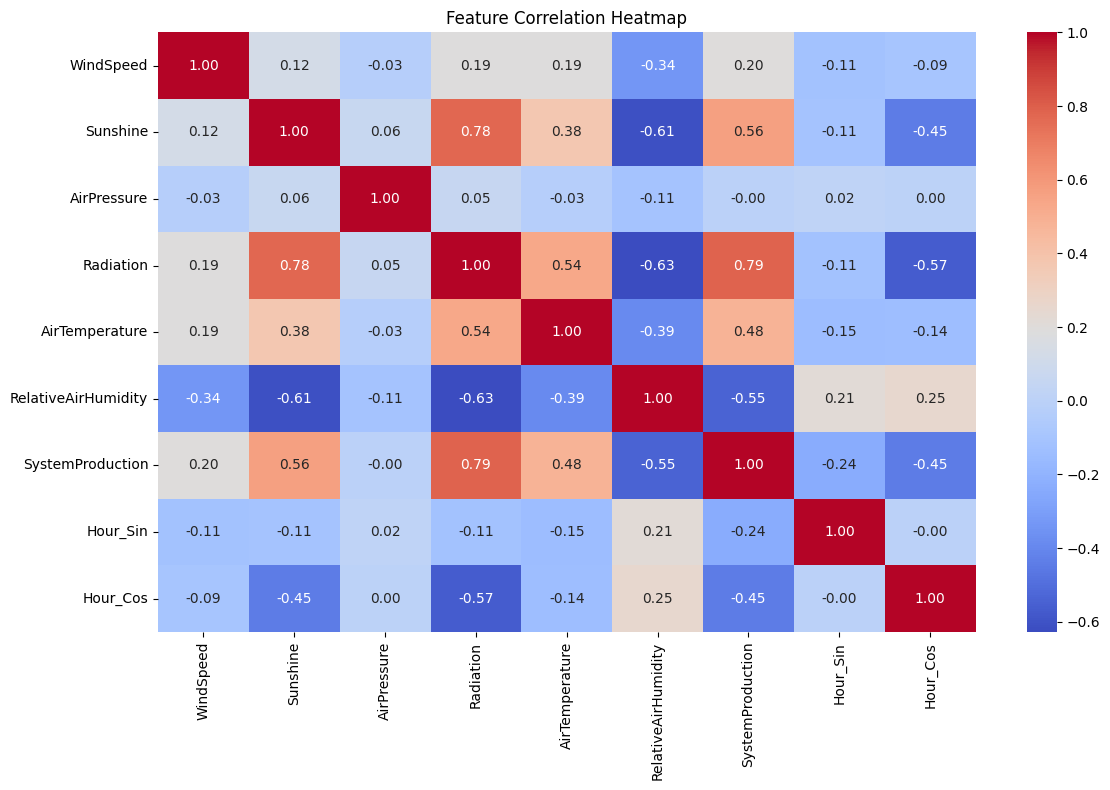

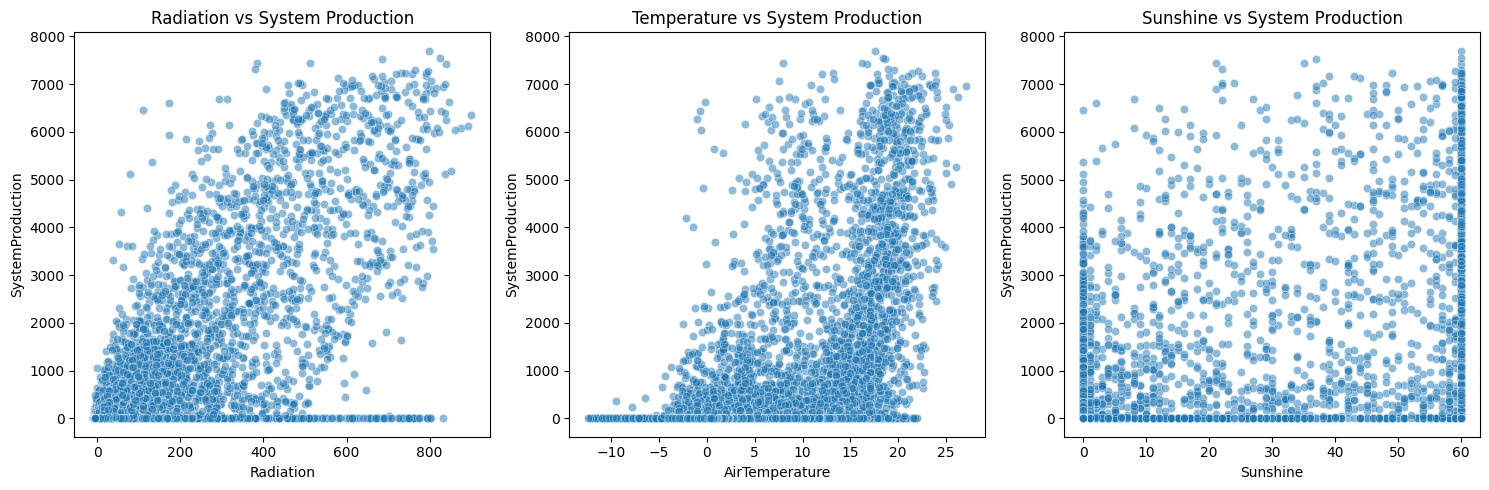

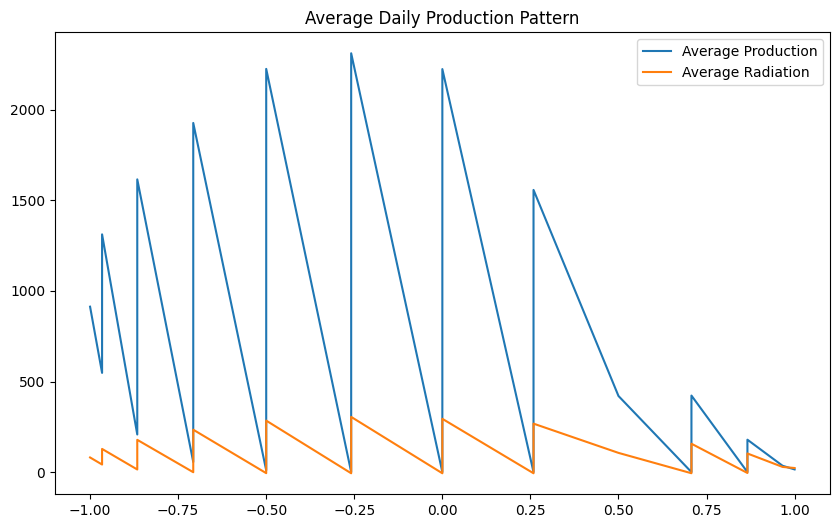


Model info saved as 'solar_model_info.joblib'

Example prediction: 0.00 kW


<ipython-input-12-519a61fe1a9b>:36: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=importance, x='importance', y='feature', palette='viridis')


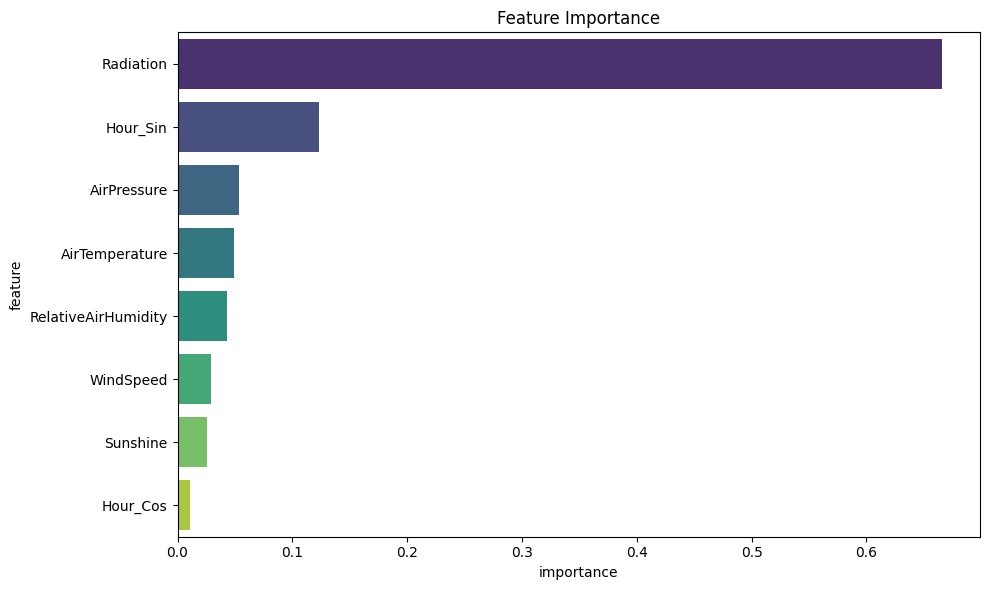


Feature Importance:
               feature  importance
3            Radiation    0.665567
6             Hour_Sin    0.122898
2          AirPressure    0.053328
4       AirTemperature    0.049198
5  RelativeAirHumidity    0.043170
0            WindSpeed    0.028890
1             Sunshine    0.026072
7             Hour_Cos    0.010876


In [12]:

if __name__ == "__main__":
    # Load data
    data = pd.read_csv('solar_data.csv')

    # Preprocess data
    processed_data = preprocess_data(data)

    # Create visualizations
    create_visualizations(processed_data)

    # Prepare features and target
    X = processed_data.drop('SystemProduction', axis=1)
    y = processed_data['SystemProduction']

    # Train and evaluate models
    model_info, results = train_evaluate_models(X, y)

    # Save model info
    joblib.dump(model_info, 'solar_model_info.joblib')

    print("\nModel info saved as 'solar_model_info.joblib'")

    # Example prediction
    example_data = X.iloc[0].to_dict()
    prediction = make_prediction(model_info, example_data)
    print(f"\nExample prediction: {prediction:.2f} kW")

    # Feature importance for Random Forest
    if isinstance(model_info['model'], RandomForestRegressor):
        importance = pd.DataFrame({
            'feature': model_info['feature_names'],
            'importance': model_info['model'].feature_importances_
        }).sort_values('importance', ascending=False)

        plt.figure(figsize=(10, 6))
        sns.barplot(data=importance, x='importance', y='feature', palette='viridis')
        plt.title('Feature Importance')
        plt.tight_layout()
        plt.savefig('feature_importance.png')
        plt.show()
        print("\nFeature Importance:")
        print(importance)